In [199]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

import numpy as np
from matplotlib import pyplot as plt

In [200]:
# Set autograd to debug mode
# torch.autograd.set_detect_anomaly(True)

## Load and reduce the data

Load the MNIST data and check number of training and test examples

In [201]:
# transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

train_data = train_dataset.data
train_targets = train_dataset.targets
test_data = test_dataset.data
test_targets = test_dataset.targets

print("Number of original training examples:", len(train_data))
print("Number of original test examples:", len(test_data))

Number of original training examples: 60000
Number of original test examples: 10000


In [202]:
# # Rescale the images to be between 0 and 1
train_data = train_data.float()
test_data = test_data.float()

In [203]:
# Print the shapes of the data
print(f"train_data.shape = {train_data.shape}")
print(f"test_data.shape = {test_data.shape}")

train_data.shape = torch.Size([60000, 28, 28])
test_data.shape = torch.Size([10000, 28, 28])


Create a function to filter out only 0 and 1

In [204]:
def filter_17(data, targets):
    indices = (targets == 1) | (targets == 7)
    data, targets = data[indices], targets[indices]
    targets = targets == 1
    return data, targets

train_data, train_targets = filter_17(train_data, train_targets)
test_data, test_targets = filter_17(test_data, test_targets)

print("Number of filtered training examples:", len(train_data))
print("Number of filtered test examples:", len(test_data))

Number of filtered training examples: 13007
Number of filtered test examples: 2163


## Plot the original images

In [1]:
plt.imshow(train_data[4], cmap='Greys')
ax = plt.gca()
ax.set_xticks([])
ax.set_yticks([])
plt.title("28x28 image in the dataset", fontsize=20)
plt.show()

NameError: name 'plt' is not defined

In [206]:
# Change to hinge loss
train_targets = 2.0 * train_targets - 1.0
test_targets = 2.0 * test_targets - 1.0

In [207]:
def hinge_accuracy(y_true, y_pred):
    # Squeeze the tensors and compare each element to 0.0
    y_true = torch.squeeze(y_true) > 0.0
    y_pred = torch.squeeze(y_pred) > 0.0
    # Compare predicted and true values, cast to float, and compute the mean
    result = (y_true == y_pred).float()
    return torch.mean(result)

In [208]:
# Add channel dimension
train_data = train_data.unsqueeze(1)
test_data = test_data.unsqueeze(1)

In [209]:
EPOCHS = 25
BATCH_SIZE = 32
NUM_EXAMPLES_TRAIN = 250
# NUM_EXAMPLES_TEST = 250

In [210]:
# Take only the first 1000 examples for training and 250 for testing
train_data, train_targets = train_data[:NUM_EXAMPLES_TRAIN], train_targets[:NUM_EXAMPLES_TRAIN]
# test_data, test_targets = test_data[:NUM_EXAMPLES_TEST], test_targets[:NUM_EXAMPLES_TEST]

print("Number of training examples:", len(train_data))
print("Number of test examples:", len(test_data))

Number of training examples: 250
Number of test examples: 2163


In [211]:
train_loader = DataLoader(list(zip(train_data, train_targets)), batch_size=BATCH_SIZE, shuffle=True)

# Hybrid QNN with Compression

In [212]:
n_qubits = 10
n_layers = 1
dev = qml.device("default.qubit", wires=n_qubits)
@qml.qnode(dev, interface="torch")
def qnode(inputs, weights):

    if len(inputs.shape) == 1:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[ii], wires=ii)
    else:
        for ii in range(n_qubits):
            qml.RY(np.pi * inputs[:,ii], wires=ii)

    for jj in range(n_layers):
        for ii in range(n_qubits-1):
            qml.RZ(weights[jj,2*ii,0], wires=0)
            qml.RY(weights[jj,2*ii,1], wires=0)
            qml.RZ(weights[jj,2*ii,2], wires=0)

            qml.RZ(weights[jj,2*ii+1,0], wires=ii+1)
            qml.RY(weights[jj,2*ii+1,1], wires=ii+1)
            qml.RZ(weights[jj,2*ii+1,2], wires=ii+1)

            qml.CNOT(wires=[ii+1,0])
            
        qml.RZ(weights[jj,2*(n_qubits-1),0], wires=0)
        qml.RY(weights[jj,2*(n_qubits-1),1], wires=0)
        qml.RZ(weights[jj,2*(n_qubits-1),2], wires=0)

    return qml.expval(qml.PauliZ(0))

weight_shapes = {"weights": (n_layers, 2*(n_qubits-1)+1, 3)}
print(weight_shapes)

{'weights': (1, 19, 3)}


In [213]:
class HCQNN(nn.Module):
    def __init__(self):
        super(HCQNN, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.pre_blocks = nn.Sequential(
            nn.Linear(32 * 7 * 7, n_qubits),
            nn.Sigmoid()
        )

        self.quantum_layer = qml.qnn.TorchLayer(qnode, weight_shapes)

        self.post_blocks = nn.Sequential(
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.pre_blocks(x)
        x = self.quantum_layer(x)
        x = self.post_blocks(x)
        return  x

In [214]:
hybrid_model = HCQNN()
print(hybrid_model)
print(f"Number of parameters: {sum(p.numel() for p in hybrid_model.parameters())}")

HCQNN(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (pre_blocks): Sequential(
    (0): Linear(in_features=1568, out_features=10, bias=True)
    (1): Sigmoid()
  )
  (quantum_layer): <Quantum Torch Layer: func=qnode>
  (post_blocks): Sequential(
    (0): Tanh()
  )
)
Number of parameters: 20547


In [215]:
criterion = nn.HingeEmbeddingLoss(margin=1)
optimizer = optim.Adam(hybrid_model.parameters(), lr=1e-4)

In [216]:
hybrid_accs = []
hybrid_losses = []

In [217]:
# Get initial loss and accuracy
hybrid_model.eval()
with torch.no_grad():
    train_acc = hinge_accuracy(train_targets, hybrid_model(train_data))
    test_acc = hinge_accuracy(test_targets, hybrid_model(test_data))
    hybrid_accs.append(test_acc.item())
print(f"Initial Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Initial Train Accuracy: 0.5440000295639038, Test Accuracy: 0.470642626285553


In [218]:
q_layer_params = []
for epoch in range(EPOCHS):
    hybrid_model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = -hybrid_model(x_batch)

        loss = criterion(y_pred, y_batch)
        hybrid_losses.append(loss.item())

        loss.backward()
        optimizer.step()

        # Add the parameters to the list
        q_layer_params.append([p.detach().numpy().copy() for p in hybrid_model.quantum_layer.parameters()])

    hybrid_model.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, hybrid_model(train_data))
        test_acc = hinge_accuracy(test_targets, hybrid_model(test_data))
        hybrid_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.7160000205039978, Test Accuracy: 0.6597318649291992
Epoch 2/25, Train Accuracy: 0.7440000176429749, Test Accuracy: 0.7128987312316895
Epoch 3/25, Train Accuracy: 0.7720000147819519, Test Accuracy: 0.7309292554855347
Epoch 4/25, Train Accuracy: 0.8199999928474426, Test Accuracy: 0.7716134786605835
Epoch 5/25, Train Accuracy: 0.8320000171661377, Test Accuracy: 0.7656033039093018
Epoch 6/25, Train Accuracy: 0.8560000061988831, Test Accuracy: 0.7928802371025085
Epoch 7/25, Train Accuracy: 0.8920000195503235, Test Accuracy: 0.8150716423988342


KeyboardInterrupt: 

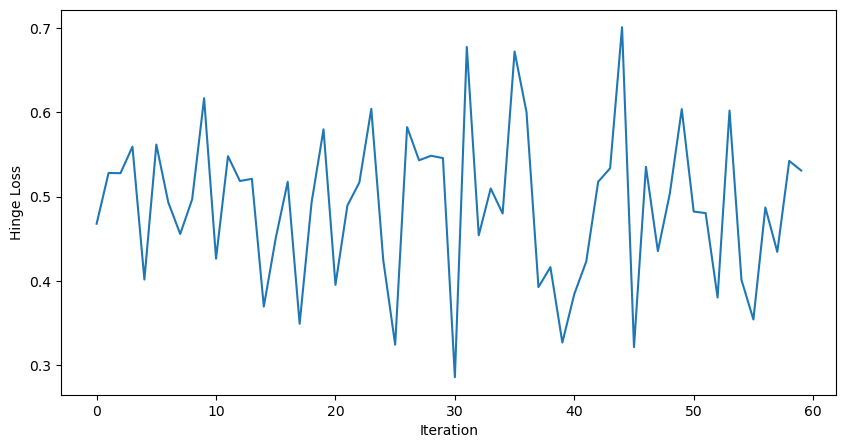

In [219]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(hybrid_losses)
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")
plt.show()

In [221]:
# Plot the weights of the quantum layer over time
q_layer_params = np.array(q_layer_params)
# Reshape to
q_layer_params = q_layer_params.reshape(-1, 19, 3)
q_layer_params.shape

(59, 19, 3)

In [223]:
q_layer_params

array([[[3.3272111 , 5.929965  , 4.44378   ],
        [0.9186002 , 2.1537716 , 1.0796521 ],
        [2.774937  , 2.9951801 , 0.02180531],
        ...,
        [0.692847  , 4.0398817 , 5.9456744 ],
        [4.2936015 , 0.5793999 , 2.4900072 ],
        [3.086196  , 2.0455139 , 2.1337543 ]],

       [[3.3271127 , 5.9298654 , 4.4437556 ],
        [0.91851354, 2.1538599 , 1.0796509 ],
        [2.7748992 , 2.9950824 , 0.0217979 ],
        ...,
        [0.69279116, 4.0398006 , 5.9457245 ],
        [4.2935014 , 0.5794998 , 2.4900072 ],
        [3.0862477 , 2.045451  , 2.1337543 ]],

       [[3.3270252 , 5.929767  , 4.443689  ],
        [0.91848046, 2.1539316 , 1.0796499 ],
        [2.7748313 , 2.9949834 , 0.0218431 ],
        ...,
        [0.6927161 , 4.0397196 , 5.945799  ],
        [4.2934356 , 0.5794795 , 2.4900072 ],
        [3.086315  , 2.045483  , 2.1337543 ]],

       ...,

       [[3.3293278 , 5.9244833 , 4.443729  ],
        [0.91498643, 2.1598315 , 1.0796442 ],
        [2.7697158 , 2

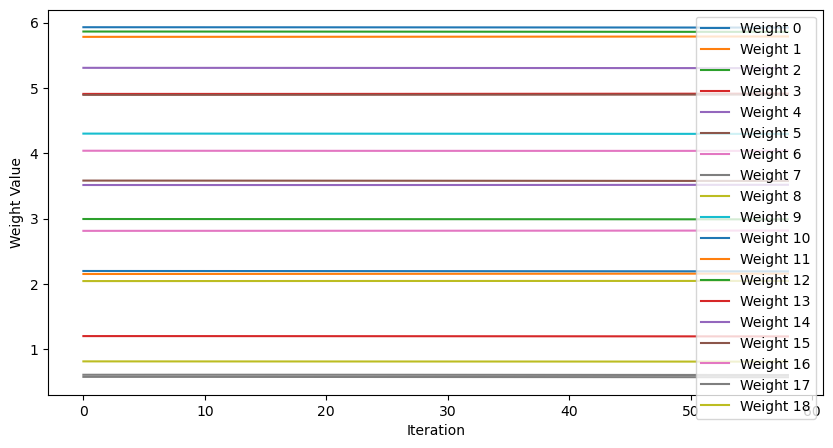

In [222]:
plt.figure(figsize=(10, 5))
for ii in range(19):
    plt.plot(q_layer_params[:,ii,1], label=f"Weight {ii}")
plt.xlabel("Iteration")
plt.ylabel("Weight Value")
plt.legend()
plt.show()

# Standard CNN

In [19]:
class Standard(nn.Module):
    def __init__(self):
        super(Standard, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.blocks = nn.Sequential(
            nn.Linear(32 * 7 * 7, 128),
            nn.LeakyReLU(),
            nn.Linear(128, 64),
            nn.LeakyReLU(),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = self.blocks(x)
        return x

In [20]:
standard_model = Standard()
print(standard_model)
print(f"Number of parameters: {sum(p.numel() for p in standard_model.parameters())}")

Standard(
  (conv): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): LeakyReLU(negative_slope=0.01)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (blocks): Sequential(
    (0): Linear(in_features=1568, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=64, out_features=1, bias=True)
    (5): Tanh()
  )
)
Number of parameters: 213953


In [21]:
criterion = nn.HingeEmbeddingLoss(margin=1)
optimizer = optim.Adam(standard_model.parameters(), lr=0.001)

In [22]:
standard_accs = []
standard_losses = []
for epoch in range(EPOCHS):
    losses = []
    standard_model.train()
    for x_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = standard_model(x_batch)
        loss = -criterion(y_pred, y_batch)
        standard_losses.append(loss.item())

        loss.backward()
        # Clip the gradients to avoid exploding gradients
        nn.utils.clip_grad_norm_(standard_model.parameters(), 1)
        optimizer.step()
        losses.append(loss.item())

    standard_model.eval()
    with torch.no_grad():
        train_acc = hinge_accuracy(train_targets, standard_model(train_data))
        test_acc = hinge_accuracy(test_targets, standard_model(test_data))
        standard_accs.append(test_acc.item())
    print(f"Epoch {epoch+1}/{EPOCHS}, Train Accuracy: {train_acc.item()}, Test Accuracy: {test_acc.item()}")

Epoch 1/25, Train Accuracy: 0.4399999976158142, Test Accuracy: 0.4863615334033966
Epoch 2/25, Train Accuracy: 0.4399999976158142, Test Accuracy: 0.4868238568305969
Epoch 3/25, Train Accuracy: 0.4399999976158142, Test Accuracy: 0.49237170815467834
Epoch 4/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.4914470613002777
Epoch 5/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.4937586784362793
Epoch 6/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.4988442063331604
Epoch 7/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.5016181468963623
Epoch 8/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.5053166747093201
Epoch 9/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.5094775557518005
Epoch 10/25, Train Accuracy: 0.44999998807907104, Test Accuracy: 0.5127138495445251
Epoch 11/25, Train Accuracy: 0.4699999988079071, Test Accuracy: 0.5210356116294861
Epoch 12/25, Train Accuracy: 0.47999998927116394, Test Accuracy: 0.5265834331512451
Epoc

In [23]:
print(standard_model(x_batch))

tensor([[-0.1297],
        [-0.8752],
        [-0.2324],
        [-0.4319]], grad_fn=<TanhBackward0>)


## Plot the results!

In [ ]:
# Plot loss for both models
plt.figure(figsize=(10, 5))
plt.plot(hybrid_losses, label="Hybrid")
plt.plot(standard_losses, label="Standard")
plt.xlabel("Iteration")
plt.ylabel("Hinge Loss")
plt.legend()
plt.show()

In [ ]:
# Plot the hinge accuracy for the QNN history for both 1 and 2 layer on the same axes
plt.figure(figsize=(10, 5))
plt.plot(hybrid_accs, label="1 Layer")
plt.plot(standard_accs, label="2 Layers")
plt.xlabel("Epoch")
plt.ylabel("Hinge Accuracy")
plt.legend()
plt.show()


In [ ]:
# Compare the ratio of test accuracy to number of parameters
hybrid_efficiency = hybrid_accs[-1] / sum(p.numel() for p in hybrid_model.parameters())
standard_efficiency = standard_accs[-1] / sum(p.numel() for p in standard_model.parameters())

In [ ]:
# Plot the efficiency of the models
plt.figure(figsize=(10, 5))
plt.bar(["Hybrid", "Standard"], [hybrid_efficiency, standard_efficiency])
plt.ylabel("Hinge Accuracy / Number of Parameters")
plt.show()